In [151]:
import json
import pandas as pd
import numpy as np
import re
import string
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [152]:
# --- Custom cleaner
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = X.flatten()
        return np.array([self.clean_text(text) for text in X])
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [153]:
# --- Load and prepare data
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

In [154]:
def label_sentiment(df):
    def get_sentiment(score):
        if score < 3:
            return 'Negative'
        elif score == 3:
            return 'Neutral'
        else:
            return 'Positive'
    df['sentiment'] = df['overall'].apply(get_sentiment)
    return df

In [155]:
df = load_json("Data.json")[["asin","reviewText","overall"]]
df

,asin,reviewText,overall
0,1384719342,"Not much to write about here, but it does exac...",5.0
1,1384719342,The product does exactly as it should and is q...,5.0
2,1384719342,The primary job of this device is to block the...,5.0
3,1384719342,Nice windscreen protects my MXL mic and preven...,5.0
4,1384719342,This pop filter is great. It looks and perform...,5.0
...,...,...,...
10256,B00JBIVXGC,"Great, just as expected. Thank to all.",5.0
10257,B00JBIVXGC,I've been thinking about trying the Nanoweb st...,5.0
10258,B00JBIVXGC,I have tried coated strings in the past ( incl...,4.0
10259,B00JBIVXGC,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0


In [156]:
df = label_sentiment(df)
df

,asin,reviewText,overall,sentiment
0,1384719342,"Not much to write about here, but it does exac...",5.0,Positive
1,1384719342,The product does exactly as it should and is q...,5.0,Positive
2,1384719342,The primary job of this device is to block the...,5.0,Positive
3,1384719342,Nice windscreen protects my MXL mic and preven...,5.0,Positive
4,1384719342,This pop filter is great. It looks and perform...,5.0,Positive
...,...,...,...,...
10256,B00JBIVXGC,"Great, just as expected. Thank to all.",5.0,Positive
10257,B00JBIVXGC,I've been thinking about trying the Nanoweb st...,5.0,Positive
10258,B00JBIVXGC,I have tried coated strings in the past ( incl...,4.0,Positive
10259,B00JBIVXGC,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Positive


In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'].values, df['sentiment'].values, test_size=0.2, random_state=42, stratify=df['sentiment']
)

In [158]:
#Build and apply the preprocessor pipeline (cleaning + tf-idf)
preprocess_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english')),
])

X_train_vec = preprocess_pipeline.fit_transform(X_train)
X_test_vec = preprocess_pipeline.transform(X_test)

In [159]:
#Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

In [160]:
#Train classifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC


clf = LogisticRegression(max_iter=1000)
clf1 = SVC(kernel='linear',probability=True)

clf.fit(X_train_resampled, y_train_resampled)
clf1.fit(X_train_resampled, y_train_resampled)


SVC(kernel='linear', probability=True)

Classification Report:

              precision    recall  f1-score   support

    Negative       0.37      0.45      0.41        93
     Neutral       0.23      0.33      0.27       155
    Positive       0.93      0.89      0.91      1805

    accuracy                           0.83      2053
   macro avg       0.51      0.56      0.53      2053
weighted avg       0.85      0.83      0.84      2053



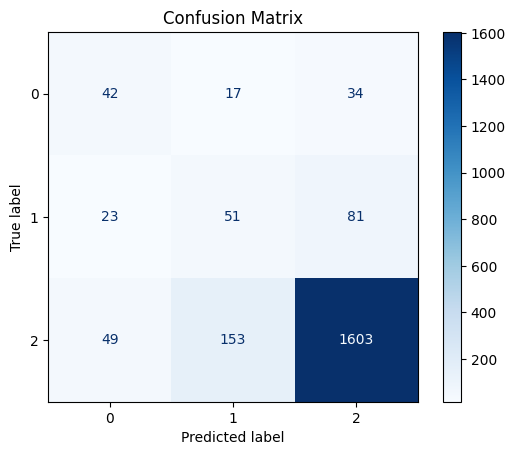

In [161]:
#=Evaluate
y_pred = clf.predict(X_test_vec)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Classification Report:

              precision    recall  f1-score   support

    Negative       0.42      0.30      0.35        93
     Neutral       0.23      0.24      0.23       155
    Positive       0.92      0.93      0.92      1805

    accuracy                           0.85      2053
   macro avg       0.52      0.49      0.50      2053
weighted avg       0.84      0.85      0.84      2053



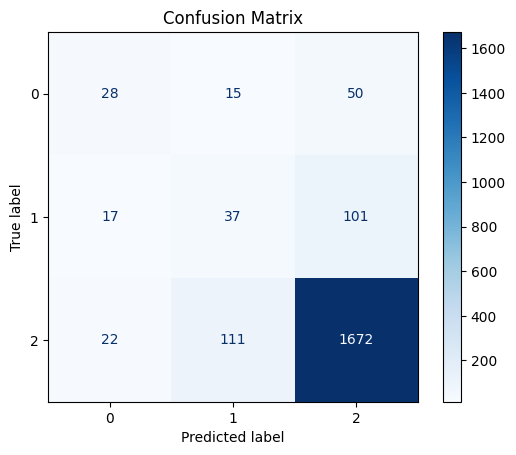

In [162]:
#=Evaluate
y_pred = clf1.predict(X_test_vec)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [163]:
#Save the full pipeline (cleaner + tfidf + trained model)
fitted_vectorizer = preprocess_pipeline.named_steps['tfidf']

final_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', fitted_vectorizer),
    ('clf', clf)
])

joblib.dump(final_pipeline, "/pipeline.pkl")
print("Saved pipeline to pipeline.pkl")


Saved pipeline to pipeline.pkl


In [164]:
pipeline = joblib.load("pipeline.pkl")
x = np.array(["I picked up this VIENON 4-Port USB 3.0 Hub to expand my laptop\u2019s USB ports, and it\u2019s been working great. Plug-and-play setup was super easy, and all four ports work without any issues. The USB 3.0 speeds are fast, so transferring files doesn\u2019t slow down, and it handles multiple devices at once with no lag.The build quality feels decent\u2014not super heavy-duty, but good enough for everyday use. It\u2019s compact and lightweight, which makes it easy to throw in a bag for travel. Works perfectly for connecting flash drives, external hard drives, keyboards, and other accessories.If you need a simple, affordable USB hub that works reliably, this is a great pick!"])
new_predictions = pipeline.predict(x)
print(new_predictions)

['Positive']


c:\Users\Houssam\anaconda3\envs\DL\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Houssam\anaconda3\envs\DL\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Houssam\anaconda3\envs\DL\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using versi

In [165]:
test = TextCleaner()
x = np.array(["aaa","bbasjabs","jqzdhqu"])
ss = pd.Series(x).fillna("").astype(str)
test.clean_text(x[0])
new_predictions = pipeline.predict(ss)
new_predictions

array(['Positive', 'Positive', 'Positive'], dtype=object)

In [166]:
ss.to_numpy()
for x in ss:
    print(x)

aaa
bbasjabs
jqzdhqu
